### **Forecasting Traffic Flow and EV Charging Demand Using Time Series and Deep Learning**

## **Introduction**

Urban traffic congestion and the rising demand for electric vehicle (EV) infrastructure pose significant challenges to smart city planning and energy management. With the growing adoption of EVs, accurately forecasting traffic patterns and charging demand has become essential for optimizing route planning and enhancing the accessibility of charging stations. This study focuses on leveraging **hourly traffic data from California District 3** and **EV charging datasets** to build an integrated forecasting framework using **hierarchical time series models**, **deep learning**, and **graph-based techniques**.

## **Project Objectives**

This project explores two major directions:

###  1. **Path Planning Based on Traffic Flow Forecasting**
- Model and forecast traffic flow using classical, hierarchical, and deep learning approaches.
- Enable intelligent routing decisions that reduce congestion based on predicted flow.

###  2. **Forecasting EV Charging Demand at Multiple Aggregation Levels**
- Predict EV charging loads across different temporal and spatial resolutions.
- Assess the relationship between traffic patterns and EV charging behaviors.

---

## **Approach & Methodology**

The analysis will follow a structured multi-step approach:

1. **Data Collection & Exploration**
   - Process 3 months of **hourly traffic data** from **PeMS (District 3)**.
   - Perform clustering using **Coefficient of Variation (CV)** to group time series.
   - Visualize temporal trends (hourly, daily, weekly) and assess missing values.

2. **Feature Engineering**
   - Extract and encode time-based features (hour, day of week, holiday, etc.).
   - Generate lag features and rolling window statistics for capturing temporal dependencies.
   - Encode cyclical features (e.g. sin/cos of hour) and spatial information if available.

3. **Baseline Forecasting Models**
   - Implement classical models: **Seasonal Naive and Linear Modelling**.
   - Establish performance baselines for comparison.

4. **Deep Learning and Graph-based Models**
   - Apply **LSTM** and **Graph Neural Network (GNN)** architectures to capture complex spatio-temporal patterns.
   - Explore **network time series modeling** to handle spatially connected sensor data.

5. **Hierarchical Time Series Modeling**
   - Develop **HTS models** for forecasting at different aggregation levels.
   - Reconcile forecasts from station to region level for interpretability and control.

6. **EV Charging Demand Forecasting**
   - Integrate **EV charging dataset** for demand modeling.
   - Forecast charging load at varying levels of aggregation using spectral clustering and deep learning.

7. **Joint Modeling for Traffic and EV Demand**
   - Explore co-dependencies between traffic flow and EV charging needs.
   - Develop a unified deep learning framework that considers both traffic flow and EV energy demands.

---

## **Data Sources**

 **Traffic Data (PeMS - Caltrans District 3)**
   - [PeMS Clearinghouse](https://pems.dot.ca.gov/?dnode=Clearinghouse&type=station_hour&district_id=3&submit=Submit)
   - 3-month hourly data including total flow, occupancy, and speed.

---

## **Why This Study Matters**

This project will provide a **data-driven decision support system** for:
- Reducing **traffic congestion** through accurate flow forecasting.
- Improving **EV charging infrastructure placement**.
- Enhancing **sustainable mobility** by integrating traffic and energy demand insights.

By combining **time series modeling**, **deep learning**, and **graph-based methods**, this study aims to bridge the gap between traffic data analysis and EV energy demand forecasting in smart cities.

In [6]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout

In [2]:
# Define folder path where the .txt files are located
folder_path = r"C:\Users\attafuro\Desktop\EV Charging Analysis"
output_file = os.path.join(folder_path, "merged_3months_traffic_data.csv")

# Get all .txt files in the folder
file_paths = glob.glob(os.path.join(folder_path, "*.txt"))

# Merge all .txt files into one CSV and delete the originals
with open(output_file, "w") as output:
    first_file = True

    for file in file_paths:
        print(f"Processing: {file}")
        
        # Read and write the .txt file in chunks (to handle large files efficiently)
        for chunk in pd.read_csv(file, delimiter=",", chunksize=10000):
            chunk.to_csv(output, index=False, header=first_file, mode="a")
            first_file = False

        # Delete the file after processing
        os.remove(file)
        print(f"Deleted: {file}")

print(f" Merge completed! CSV saved as '{output_file}'")


Processing: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_10.txt
Deleted: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_10.txt
Processing: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_11.txt
Deleted: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_11.txt
Processing: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_12.txt
Deleted: C:\Users\attafuro\Desktop\EV Charging Analysis\d03_text_station_hour_2024_12.txt
 Merge completed! CSV saved as 'C:\Users\attafuro\Desktop\EV Charging Analysis\merged_3months_traffic_data.csv'


# Loading Data

In [5]:
# Load the merged file
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\merged_3months_traffic_data.csv")

# Display basic info
df.head()

,10/01/2024 00:00:00,308511,3,50,E,ML,3.134,202,92,20,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning and EDA

In [7]:
# Define the correct column names
column_names = [
    "Timestamp", "Station", "District", "Route", "Direction of Travel", "Lane Type",
    "Station Length", "Samples", "% Observed", "Total Flow", "Avg Occupancy", "Avg Speed",
    "Delay (V_t=35)", "Delay (V_t=40)", "Delay (V_t=45)", "Delay (V_t=50)", "Delay (V_t=55)", "Delay (V_t=60)"
]

In [9]:
# Identify extra columns (Lane N data) and rename accordingly
num_extra_cols = len(df.columns) - len(column_names)
for i in range(1, num_extra_cols // 3 + 1):  
    column_names.extend([
        f"Lane {i} Flow", f"Lane {i} Avg Occ", f"Lane {i} Avg Speed"
    ])

# Apply new column names
df.columns = column_names

# Save the cleaned dataset
cleaned_file_path = r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv"
df.to_csv(cleaned_file_path, index=False)

print(f" Column names fixed! Cleaned data saved as '{cleaned_file_path}'.")

 Column names fixed! Cleaned data saved as 'C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv'.


In [10]:
# Convert 'Timestamp' to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%m/%d/%Y %H:%M:%S")

In [11]:
df.head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,2024-10-01,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-01,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-01,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-01,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-01,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [13]:
# Display initial summary
print(" Initial Data Overview:")
print(df.info())  # Check data types

 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114680 entries, 0 to 4114679
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Timestamp            datetime64[ns]
 1   Station              int64         
 2   Route                int64         
 3   Direction of Travel  object        
 4   Total Flow           float64       
 5   Avg Speed            float64       
 6   % Observed           int64         
 7   Samples              int64         
 8   Lane Type            object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 282.5+ MB
None


In [14]:
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values


Missing Values:
 Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64


In [26]:
df = df.loc[:, df.columns != "Avg Speed"]

In [19]:
# Fill Total Flow missing values with median of same Route & Lane Type
df['Total Flow'] = df.groupby(['Route', 'Lane Type'])['Total Flow'].transform(lambda x: x.fillna(x.median()))

In [29]:
df["Total Flow"] = df["Total Flow"].fillna(df["Total Flow"].median())

In [30]:
print(" Missing Values After Cleaning:\n", df.isnull().sum())

 Missing Values After Cleaning:
 Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64


In [31]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,2024-10-01,308512,50,W,497.0,0,197,ML
1,2024-10-01,311831,5,S,27.0,92,101,OR
2,2024-10-01,311832,5,S,78.0,92,101,FR
3,2024-10-01,311844,5,N,43.0,92,202,OR
4,2024-10-01,311847,5,N,73.0,92,303,OR


In [51]:
df.describe()

,Timestamp,Station,Route,Total Flow,% Observed,Samples,Hour,Week,Flow_lag_1,Flow_lag_24,Flow_lag_168,Flow_roll_mean_168,Flow_roll_std_168,Flow_roll_min_168,Flow_roll_max_168,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
count,4114680,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4114680,4.112784e+06,4.069176e+06,3.796152e+06,3.798048e+06,3.798048e+06,3.798048e+06,3.798048e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06
mean,2024-11-15 21:55:32.850477312,1.555704e+06,6.332029e+01,9.391891e+02,7.892594e+01,1.841558e+02,1.150048e+01,2024-11-12 10:58:02.999211776,9.394547e+02,9.396856e+02,9.469338e+02,9.402966e+02,5.432684e+02,1.246337e+02,1.984810e+03,-4.452053e-05,-2.475985e-05,8.797806e-03,6.963006e-03
min,2024-10-01 00:00:00,3.085110e+05,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2024-09-30 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,3.571429e-02,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01
25%,2024-10-23 20:00:00,3.160180e+05,5.000000e+01,8.800000e+01,9.200000e+01,1.010000e+02,6.000000e+00,2024-10-21 00:00:00,8.800000e+01,8.800000e+01,8.900000e+01,1.761845e+02,1.228838e+02,4.000000e+00,4.900000e+02,-7.071068e-01,-7.071068e-01,-7.818315e-01,-9.009689e-01
50%,2024-11-15 21:00:00,3.193550e+05,6.500000e+01,4.000000e+02,1.000000e+02,1.200000e+02,1.200000e+01,2024-11-11 00:00:00,4.000000e+02,4.000000e+02,4.040000e+02,4.960863e+02,3.393627e+02,2.700000e+01,1.285000e+03,0.000000e+00,-1.836970e-16,0.000000e+00,-2.225209e-01
75%,2024-12-08 22:00:00,3.048042e+06,8.000000e+01,1.205000e+03,1.000000e+02,2.400000e+02,1.800000e+01,2024-12-02 00:00:00,1.205000e+03,1.205000e+03,1.214000e+03,1.399786e+03,8.056204e+02,1.640000e+02,2.920000e+03,7.071068e-01,7.071068e-01,7.818315e-01,6.234898e-01
max,2024-12-31 23:00:00,3.900024e+06,5.050000e+02,9.913000e+03,1.000000e+02,9.600000e+02,2.300000e+01,2024-12-30 00:00:00,9.913000e+03,9.913000e+03,9.913000e+03,5.804679e+03,2.805378e+03,3.303000e+03,9.913000e+03,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00
std,NaN,1.401927e+06,3.830528e+01,1.290288e+03,3.837036e+01,1.285258e+02,6.922123e+00,NaN,1.290488e+03,1.290949e+03,1.298834e+03,1.033263e+03,5.564741e+02,2.015710e+02,1.943867e+03,7.071029e-01,7.071108e-01,7.079409e-01,7.061828e-01


In [32]:
# Extract time components
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.date
df["Week"] = df["Timestamp"].dt.to_period("W").apply(lambda r: r.start_time)

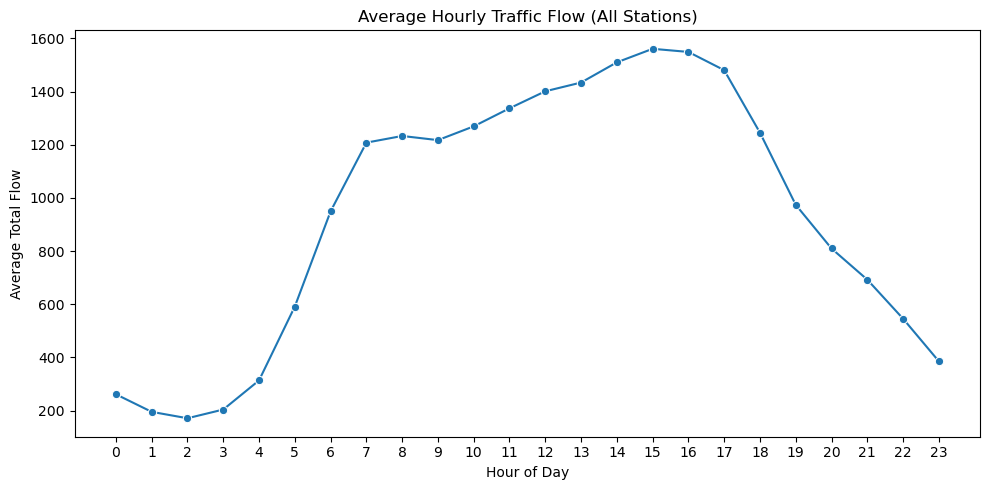

In [33]:
hourly_avg = df.groupby("Hour")["Total Flow"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_avg, x="Hour", y="Total Flow", marker="o")
plt.title("Average Hourly Traffic Flow (All Stations)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Total Flow")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

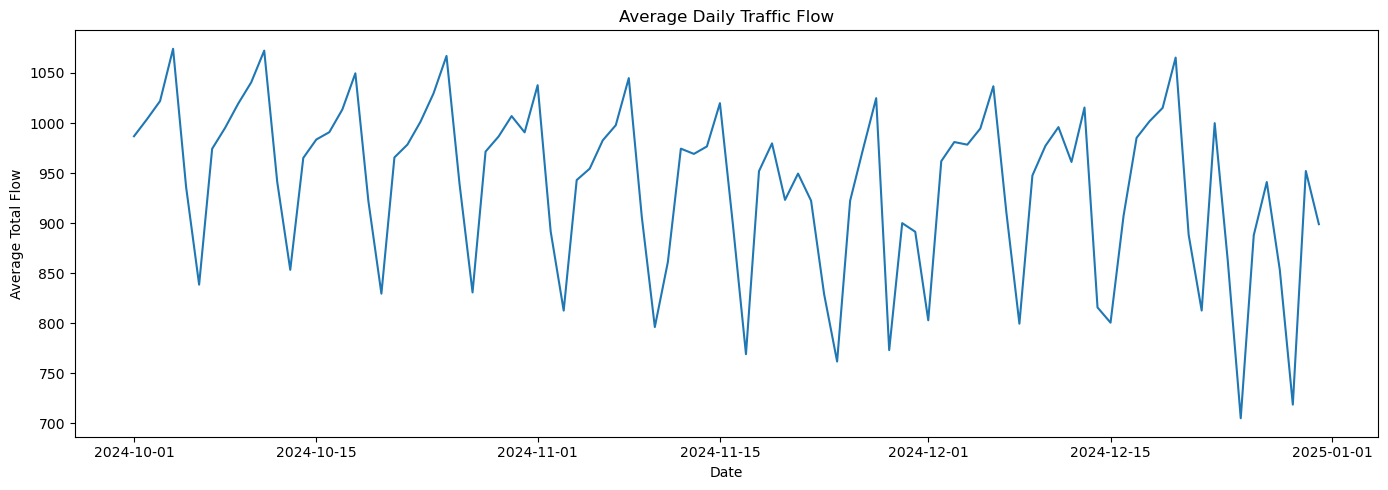

In [34]:
daily_avg = df.groupby("Day")["Total Flow"].mean().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_avg, x="Day", y="Total Flow")
plt.title("Average Daily Traffic Flow")
plt.xlabel("Date")
plt.ylabel("Average Total Flow")
plt.tight_layout()
plt.show()

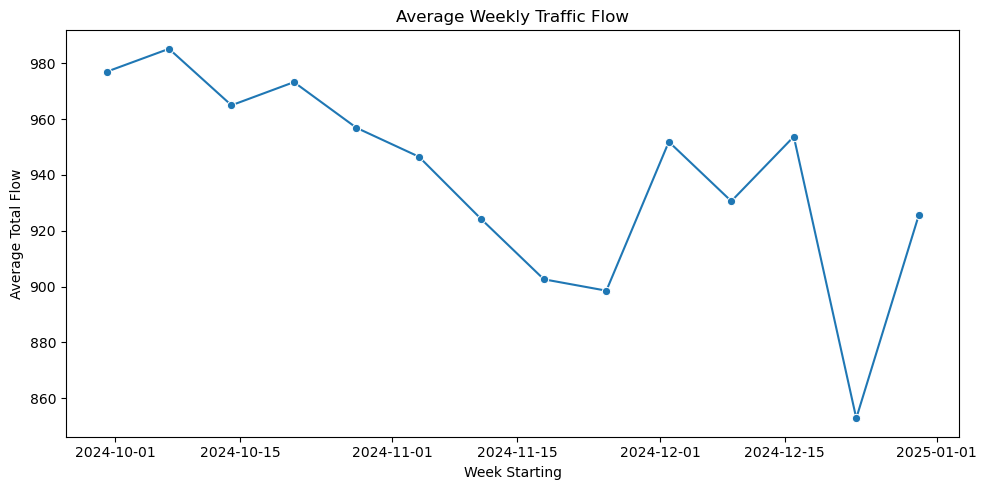

In [35]:
weekly_avg = df.groupby("Week")["Total Flow"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=weekly_avg, x="Week", y="Total Flow", marker="o")
plt.title("Average Weekly Traffic Flow")
plt.xlabel("Week Starting")
plt.ylabel("Average Total Flow")
plt.tight_layout()
plt.show()

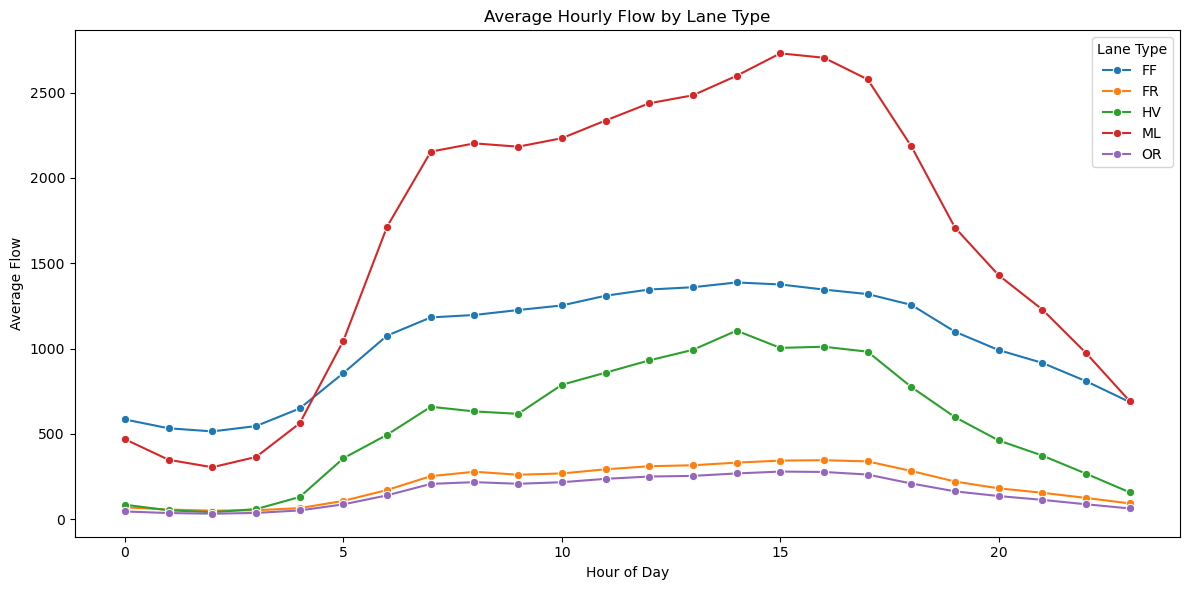

In [36]:
hourly_lane = df.groupby(["Hour", "Lane Type"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_lane, x="Hour", y="Total Flow", hue="Lane Type", marker="o")
plt.title("Average Hourly Flow by Lane Type")
plt.xlabel("Hour of Day")
plt.ylabel("Average Flow")
plt.legend(title="Lane Type")
plt.tight_layout()
plt.show()

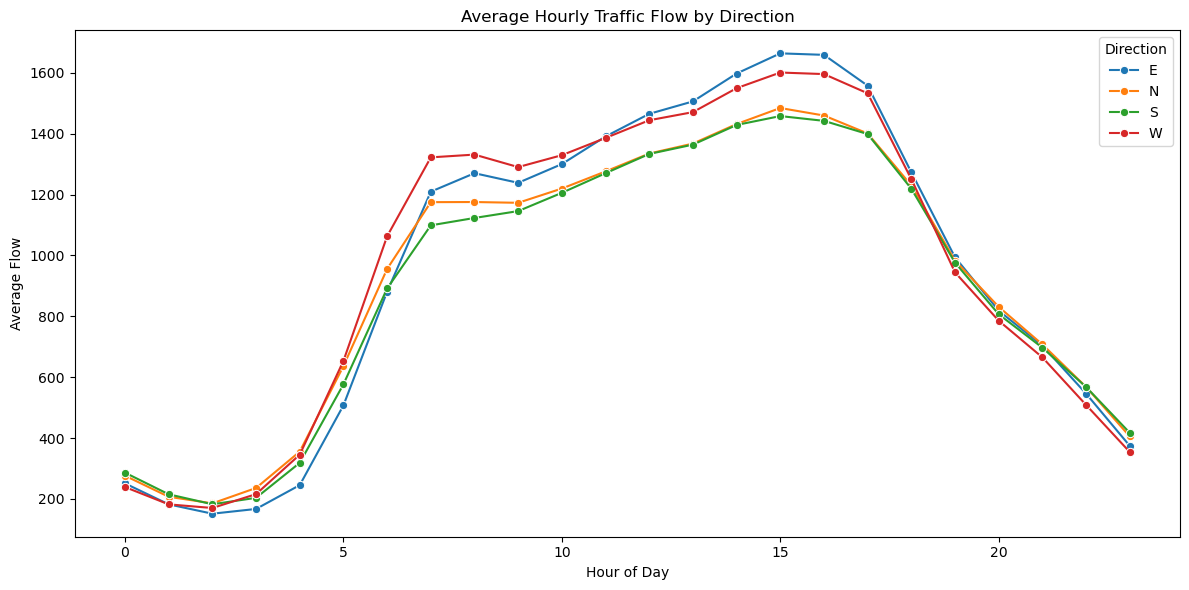

In [37]:
hourly_dir = df.groupby(["Hour", "Direction of Travel"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_dir, x="Hour", y="Total Flow", hue="Direction of Travel", marker="o")
plt.title("Average Hourly Traffic Flow by Direction")
plt.xlabel("Hour of Day")
plt.ylabel("Average Flow")
plt.legend(title="Direction")
plt.tight_layout()
plt.show()

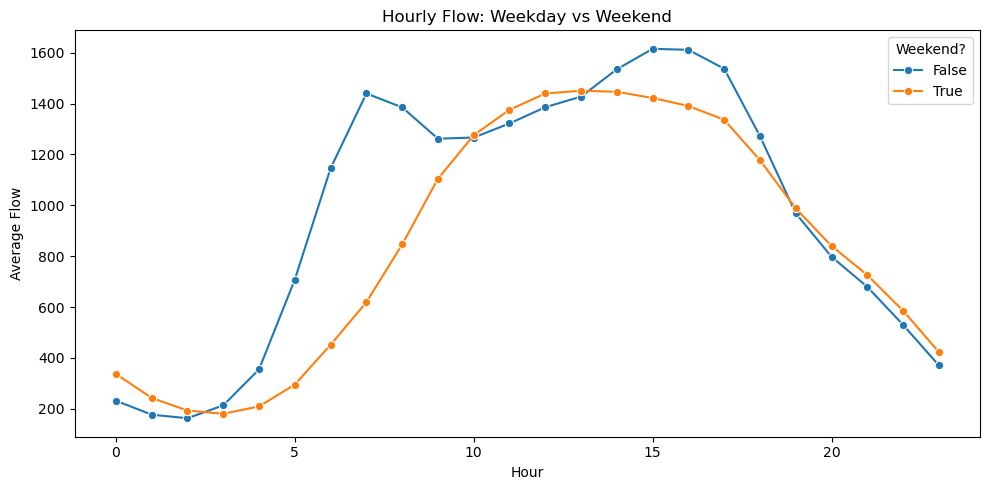

In [39]:
df["DayOfWeek"] = df["Timestamp"].dt.day_name()
df["IsWeekend"] = df["DayOfWeek"].isin(["Saturday", "Sunday"])

hourly_weekend = df.groupby(["Hour", "IsWeekend"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_weekend, x="Hour", y="Total Flow", hue="IsWeekend", marker="o")
plt.title("Hourly Flow: Weekday vs Weekend")
plt.xlabel("Hour")
plt.ylabel("Average Flow")
plt.legend(title="Weekend?")
plt.tight_layout()
plt.show()

# Feature Engineering

In [44]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Week,DayOfWeek,IsWeekend
0,2024-10-01,308512,50,W,497.0,0,197,ML,0,2024-10-01,2024-09-30,Tuesday,False
1,2024-10-01,311831,5,S,27.0,92,101,OR,0,2024-10-01,2024-09-30,Tuesday,False
2,2024-10-01,311832,5,S,78.0,92,101,FR,0,2024-10-01,2024-09-30,Tuesday,False
3,2024-10-01,311844,5,N,43.0,92,202,OR,0,2024-10-01,2024-09-30,Tuesday,False
4,2024-10-01,311847,5,N,73.0,92,303,OR,0,2024-10-01,2024-09-30,Tuesday,False


To effectively forecast traffic flow and EV charging demand, we need to transform the raw data into meaningful features that capture temporal dynamics, recurring patterns, and station-level behaviors. This section outlines a structured feature engineering pipeline tailored specifically for **hourly traffic data over a 3-month period**.

Our goal is to equip classical and deep learning models with the context they need to learn from past traffic behavior and make accurate predictions.

---

### 1. Lag Features (Memory of the Past)

**Purpose:**  
Lag features capture the value of **Total Flow** at previous time steps. These features are essential in time series forecasting because they allow the model to "remember" historical values and recognize temporal dependencies.

**Implementation:**  
We generate lag features such as:
- `t-1` → Previous hour
- `t-24` → Same hour yesterday
- `t-168` → Same hour last week (captures weekly seasonality)

**Benefit for Modeling:**  
These features are especially useful for both statistical models like ARIMA and machine learning models like LSTM, as they mimic the autoregressive structure found in many forecasting approaches.

---

### 2. Rolling Window Statistics (Local Trend & Volatility)

**Purpose:**  
Rolling window statistics smooth out short-term noise and highlight underlying trends or variability in traffic flow. They also help the model understand localized behavior such as a gradual increase in traffic during morning rush hours.

**Implementation (7-Day Window):**
- **Rolling Mean:** Average flow over past 7 days (168 hours)
- **Rolling Std:** Volatility around the trend
- **Rolling Min/Max:** Detects traffic flow extremes in recent memory

**Benefit for Modeling:**  
These features help models adapt to recent changes rather than depending only on long-term patterns.

---

### 3. Cyclical Time Encoding (Respecting Time's Nature)

**Purpose:**  
Time-based features like **hour of day** and **day of week** are inherently cyclical. For example, hour 23 and hour 0 are close in time, but numerically far apart. Standard numeric encoding fails to capture this circularity.

**Solution:**  
We apply **sine and cosine transformations** to:
- `Hour` → 24-hour cycle
- `DayOfWeek` → 7-day cycle

**Benefit for Modeling:**  
These transformations preserve the cyclical structure of time and help deep learning models (especially LSTMs and Transformers) generalize patterns that repeat daily or weekly.

---

### 4. Coefficient of Variation (CV) – Station Stability Metric

**Purpose:**  
The Coefficient of Variation (CV) quantifies how **volatile** or **stable** the traffic flow is at each station. It's calculated as:

CV = Standard Deviation\Mean


**Application:**  
We use CV to:
- Identify and group stations with similar traffic consistency
- Potentially **cluster stations** before forecasting
- Inform model complexity (e.g., use simpler models for low-CV stations)

**Benefit for Modeling:**  
Improves model personalization per station and allows for more informed hierarchical or cluster-based time series modeling.

---

### Why This Matters for Our Project

This engineered dataset is foundational to the **two major goals** of our project:
1. **Path Planning:**  
   By accurately forecasting traffic flow at fine granularity (hourly × station), we can predict congestion and suggest better routes.

2. **EV Charging Demand Forecasting:**  
   Traffic patterns are correlated with EV charging demand. Understanding flow dynamics allows us to forecast energy needs and optimize charging station operations.

Together, these features create a rich, temporal-spatial structure that empowers advanced models—statistical, machine learning, and deep learning—to learn the complex behavior of real-world traffic systems.



In [46]:
# Ensure data is sorted by station and time
df = df.sort_values(by=["Station", "Timestamp"]).copy()

### Lag Features 
df["Flow_lag_1"] = df.groupby("Station")["Total Flow"].shift(1)
df["Flow_lag_24"] = df.groupby("Station")["Total Flow"].shift(24)
df["Flow_lag_168"] = df.groupby("Station")["Total Flow"].shift(168)

### Rolling Window Stats (7 days = 168 hours) 
df["Flow_roll_mean_168"] = df.groupby("Station")["Total Flow"].transform(lambda x: x.rolling(window=168).mean())
df["Flow_roll_std_168"] = df.groupby("Station")["Total Flow"].transform(lambda x: x.rolling(window=168).std())
df["Flow_roll_min_168"] = df.groupby("Station")["Total Flow"].transform(lambda x: x.rolling(window=168).min())
df["Flow_roll_max_168"] = df.groupby("Station")["Total Flow"].transform(lambda x: x.rolling(window=168).max())

### Cyclical Encoding of Time Features 
df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)

df["DayOfWeek_sin"] = np.sin(2 * np.pi * df["Timestamp"].dt.weekday / 7)
df["DayOfWeek_cos"] = np.cos(2 * np.pi * df["Timestamp"].dt.weekday / 7)

###  Coefficient of Variation (for later clustering) 
cv_df = df.groupby("Station")["Total Flow"].agg(['mean', 'std']).reset_index()
cv_df["CV"] = cv_df["std"] / (cv_df["mean"] + 1e-6)  # Avoid division by zero


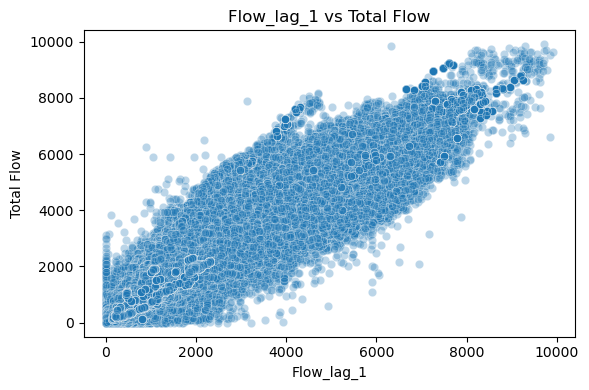

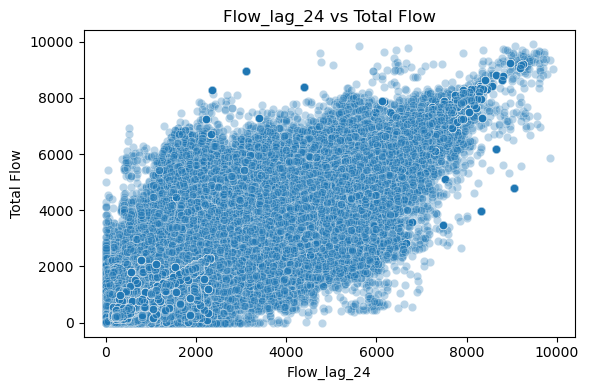

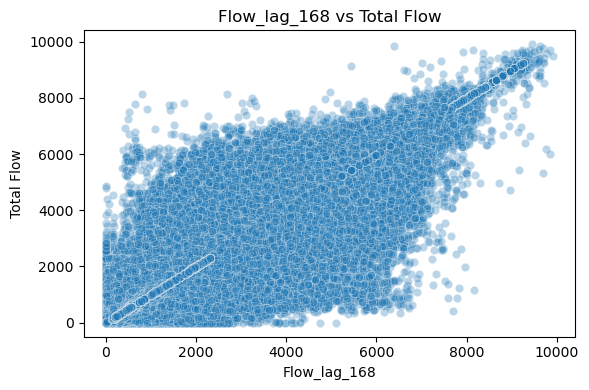

In [47]:
for lag_col in ["Flow_lag_1", "Flow_lag_24", "Flow_lag_168"]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=lag_col, y="Total Flow", alpha=0.3)
    plt.title(f"{lag_col} vs Total Flow")
    plt.xlabel(lag_col)
    plt.ylabel("Total Flow")
    plt.tight_layout()
    plt.show()

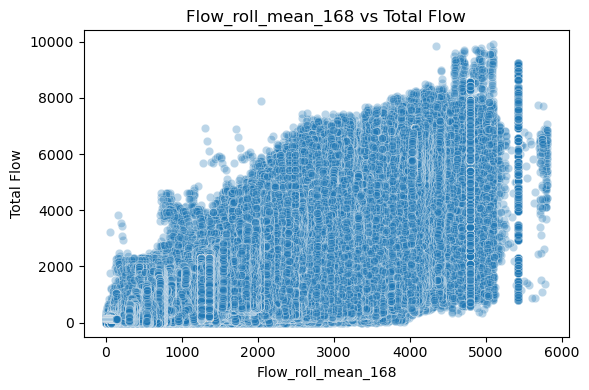

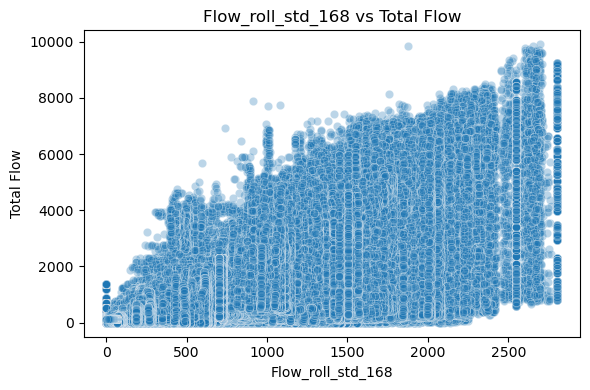

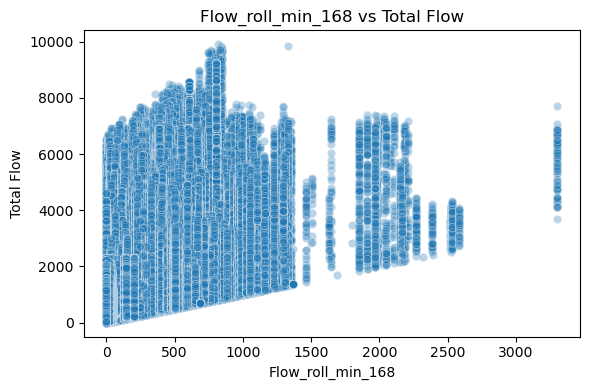

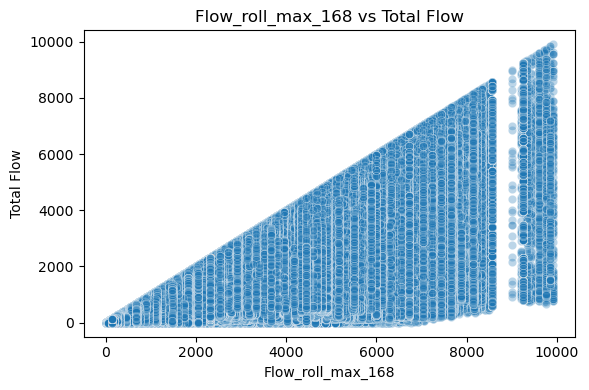

In [48]:
for roll_col in ["Flow_roll_mean_168", "Flow_roll_std_168", "Flow_roll_min_168", "Flow_roll_max_168"]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=roll_col, y="Total Flow", alpha=0.3)
    plt.title(f"{roll_col} vs Total Flow")
    plt.xlabel(roll_col)
    plt.ylabel("Total Flow")
    plt.tight_layout()
    plt.show()

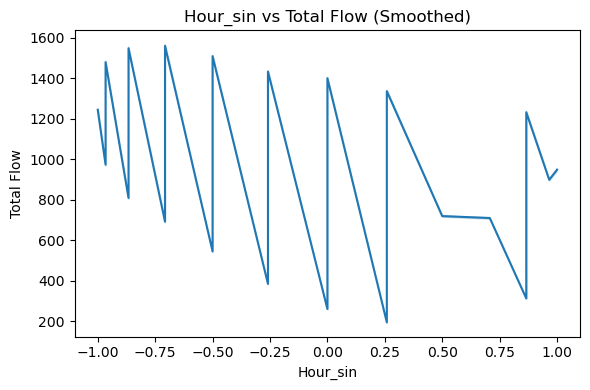

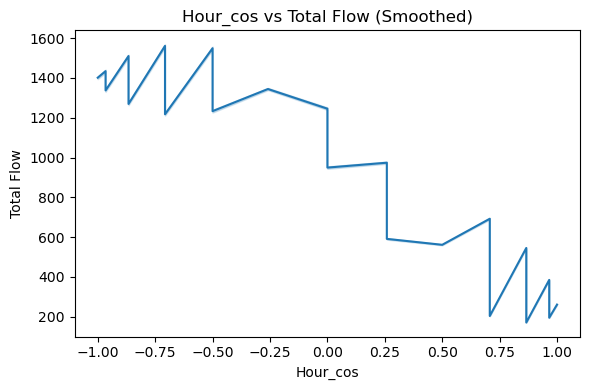

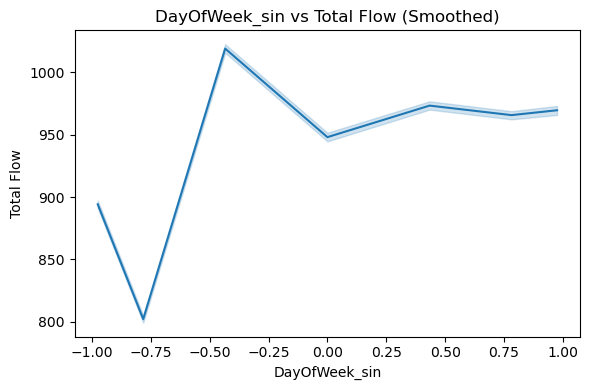

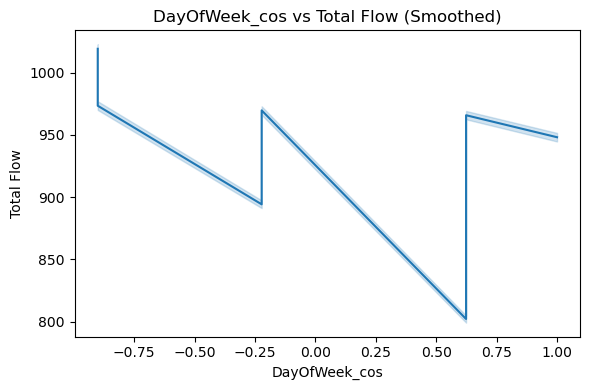

In [49]:
for cyc_col in ["Hour_sin", "Hour_cos", "DayOfWeek_sin", "DayOfWeek_cos"]:
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x=cyc_col, y="Total Flow")
    plt.title(f"{cyc_col} vs Total Flow (Smoothed)")
    plt.xlabel(cyc_col)
    plt.ylabel("Total Flow")
    plt.tight_layout()
    plt.show()

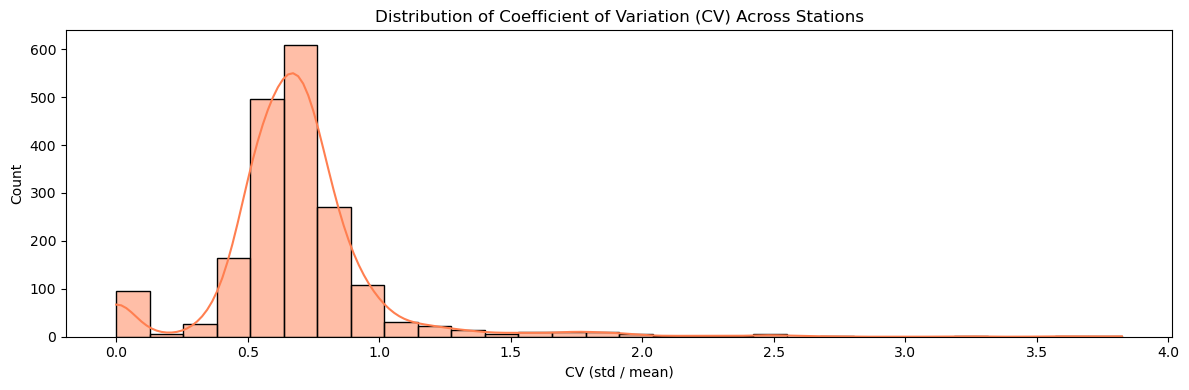

In [50]:
plt.figure(figsize=(12, 4))
sns.histplot(cv_df["CV"], bins=30, kde=True, color="coral")
plt.title("Distribution of Coefficient of Variation (CV) Across Stations")
plt.xlabel("CV (std / mean)")
plt.tight_layout()
plt.show()

In [52]:
df.describe()

,Timestamp,Station,Route,Total Flow,% Observed,Samples,Hour,Week,Flow_lag_1,Flow_lag_24,Flow_lag_168,Flow_roll_mean_168,Flow_roll_std_168,Flow_roll_min_168,Flow_roll_max_168,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
count,4114680,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4114680,4.112784e+06,4.069176e+06,3.796152e+06,3.798048e+06,3.798048e+06,3.798048e+06,3.798048e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06
mean,2024-11-15 21:55:32.850477312,1.555704e+06,6.332029e+01,9.391891e+02,7.892594e+01,1.841558e+02,1.150048e+01,2024-11-12 10:58:02.999211776,9.394547e+02,9.396856e+02,9.469338e+02,9.402966e+02,5.432684e+02,1.246337e+02,1.984810e+03,-4.452053e-05,-2.475985e-05,8.797806e-03,6.963006e-03
min,2024-10-01 00:00:00,3.085110e+05,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2024-09-30 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,3.571429e-02,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01
25%,2024-10-23 20:00:00,3.160180e+05,5.000000e+01,8.800000e+01,9.200000e+01,1.010000e+02,6.000000e+00,2024-10-21 00:00:00,8.800000e+01,8.800000e+01,8.900000e+01,1.761845e+02,1.228838e+02,4.000000e+00,4.900000e+02,-7.071068e-01,-7.071068e-01,-7.818315e-01,-9.009689e-01
50%,2024-11-15 21:00:00,3.193550e+05,6.500000e+01,4.000000e+02,1.000000e+02,1.200000e+02,1.200000e+01,2024-11-11 00:00:00,4.000000e+02,4.000000e+02,4.040000e+02,4.960863e+02,3.393627e+02,2.700000e+01,1.285000e+03,0.000000e+00,-1.836970e-16,0.000000e+00,-2.225209e-01
75%,2024-12-08 22:00:00,3.048042e+06,8.000000e+01,1.205000e+03,1.000000e+02,2.400000e+02,1.800000e+01,2024-12-02 00:00:00,1.205000e+03,1.205000e+03,1.214000e+03,1.399786e+03,8.056204e+02,1.640000e+02,2.920000e+03,7.071068e-01,7.071068e-01,7.818315e-01,6.234898e-01
max,2024-12-31 23:00:00,3.900024e+06,5.050000e+02,9.913000e+03,1.000000e+02,9.600000e+02,2.300000e+01,2024-12-30 00:00:00,9.913000e+03,9.913000e+03,9.913000e+03,5.804679e+03,2.805378e+03,3.303000e+03,9.913000e+03,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00
std,NaN,1.401927e+06,3.830528e+01,1.290288e+03,3.837036e+01,1.285258e+02,6.922123e+00,NaN,1.290488e+03,1.290949e+03,1.298834e+03,1.033263e+03,5.564741e+02,2.015710e+02,1.943867e+03,7.071029e-01,7.071108e-01,7.079409e-01,7.061828e-01


In [53]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,...,Flow_lag_24,Flow_lag_168,Flow_roll_mean_168,Flow_roll_std_168,Flow_roll_min_168,Flow_roll_max_168,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
1827,2024-10-01 01:00:00,308511,50,E,12.0,100,202,ML,1,2024-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,0.258819,0.965926,0.781831,0.62349
3688,2024-10-01 02:00:00,308511,50,E,12.0,100,197,ML,2,2024-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.866025,0.781831,0.62349
5549,2024-10-01 03:00:00,308511,50,E,20.0,92,197,ML,3,2024-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,0.707107,0.707107,0.781831,0.62349
7410,2024-10-01 04:00:00,308511,50,E,55.0,100,197,ML,4,2024-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,0.866025,0.500000,0.781831,0.62349
9271,2024-10-01 05:00:00,308511,50,E,228.0,83,168,ML,5,2024-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,0.965926,0.258819,0.781831,0.62349


In [54]:
# Drop all rows with any missing values
df = df.dropna().reset_index(drop=True)

In [56]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,...,Flow_lag_24,Flow_lag_168,Flow_roll_mean_168,Flow_roll_std_168,Flow_roll_min_168,Flow_roll_max_168,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
0,2024-10-08 01:00:00,308511,50,E,15.0,100,197,ML,1,2024-10-08,...,10.0,12.0,307.827381,214.295867,10.0,823.0,0.258819,0.965926,0.781831,0.62349
1,2024-10-08 02:00:00,308511,50,E,12.0,100,202,ML,2,2024-10-08,...,20.0,12.0,307.827381,214.295867,10.0,823.0,0.500000,0.866025,0.781831,0.62349
2,2024-10-08 03:00:00,308511,50,E,13.0,83,190,ML,3,2024-10-08,...,17.0,20.0,307.785714,214.352839,10.0,823.0,0.707107,0.707107,0.781831,0.62349
3,2024-10-08 04:00:00,308511,50,E,62.0,92,198,ML,4,2024-10-08,...,78.0,55.0,307.827381,214.304082,10.0,823.0,0.866025,0.500000,0.781831,0.62349
4,2024-10-08 05:00:00,308511,50,E,227.0,92,196,ML,5,2024-10-08,...,293.0,228.0,307.821429,214.306326,10.0,823.0,0.965926,0.258819,0.781831,0.62349


In [60]:
# Label encode 'Station'
le_station = LabelEncoder()
df["Station_encoded"] = le_station.fit_transform(df["Station"])

# Label encode 'Route'
le_route = LabelEncoder()
df["Route_encoded"] = le_route.fit_transform(df["Route"])

#  One-hot encode 'Direction of Travel' and 'Lane Type'
df = pd.get_dummies(df, columns=["Direction of Travel", "Lane Type"], prefix=["Dir", "Lane"])

In [61]:
df.head()

,Timestamp,Station,Route,Total Flow,% Observed,Samples,Hour,Day,Week,DayOfWeek,...,Route_encoded,Dir_E,Dir_N,Dir_S,Dir_W,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR
0,2024-10-08 01:00:00,308511,50,15.0,100,197,1,2024-10-08,2024-10-07,Tuesday,...,7,True,False,False,False,False,False,False,True,False
1,2024-10-08 02:00:00,308511,50,12.0,100,202,2,2024-10-08,2024-10-07,Tuesday,...,7,True,False,False,False,False,False,False,True,False
2,2024-10-08 03:00:00,308511,50,13.0,83,190,3,2024-10-08,2024-10-07,Tuesday,...,7,True,False,False,False,False,False,False,True,False
3,2024-10-08 04:00:00,308511,50,62.0,92,198,4,2024-10-08,2024-10-07,Tuesday,...,7,True,False,False,False,False,False,False,True,False
4,2024-10-08 05:00:00,308511,50,227.0,92,196,5,2024-10-08,2024-10-07,Tuesday,...,7,True,False,False,False,False,False,False,True,False


In [62]:
bool_cols = df.select_dtypes(include='bool').columns.tolist()
df[bool_cols] = df[bool_cols].astype(int)

In [64]:
df.columns

Index(['Timestamp', 'Station', 'Route', 'Total Flow', '% Observed', 'Samples',
       'Hour', 'Day', 'Week', 'DayOfWeek', 'IsWeekend', 'Flow_lag_1',
       'Flow_lag_24', 'Flow_lag_168', 'Flow_roll_mean_168',
       'Flow_roll_std_168', 'Flow_roll_min_168', 'Flow_roll_max_168',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'Station_encoded', 'Route_encoded', 'Dir_E', 'Dir_N', 'Dir_S', 'Dir_W',
       'Lane_FF', 'Lane_FR', 'Lane_HV', 'Lane_ML', 'Lane_OR'],
      dtype='object')

In [65]:
columns_to_drop = ["Timestamp", "Station", "Route","Timestamp"]

# Drop the raw columns
df.drop(columns=columns_to_drop, inplace=True)

In [68]:
df.drop(columns="DayOfWeek",inplace=True)

In [70]:
df.drop(columns=["Day", "Week"], inplace=True)

In [72]:
df.head()

,Total Flow,% Observed,Samples,Hour,IsWeekend,Flow_lag_1,Flow_lag_24,Flow_lag_168,Flow_roll_mean_168,Flow_roll_std_168,...,Route_encoded,Dir_E,Dir_N,Dir_S,Dir_W,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR
0,15.0,100,197,1,0,35.0,10.0,12.0,307.827381,214.295867,...,7,1,0,0,0,0,0,0,1,0
1,12.0,100,202,2,0,15.0,20.0,12.0,307.827381,214.295867,...,7,1,0,0,0,0,0,0,1,0
2,13.0,83,190,3,0,12.0,17.0,20.0,307.785714,214.352839,...,7,1,0,0,0,0,0,0,1,0
3,62.0,92,198,4,0,13.0,78.0,55.0,307.827381,214.304082,...,7,1,0,0,0,0,0,0,1,0
4,227.0,92,196,5,0,62.0,293.0,228.0,307.821429,214.306326,...,7,1,0,0,0,0,0,0,1,0


In [87]:
# Compute mean and standard deviation per (Station, Route)
df_grouped = df.groupby(["Route_encoded"])["Total Flow"].agg(['mean', 'std'])
df_grouped["CV"] = df_grouped["std"] / df_grouped["mean"]

# Merge back into main dataset
df = df.merge(df_grouped[["CV"]], on=["Route_encoded"], how="left")

In [75]:
target = "Total Flow"
y = df[target]

In [91]:
features_1 = [
    "Hour",
    "IsWeekend",
    "% Observed",
    "Samples"
]
X_fs1 = df[features_1]

features_2 = features_1 + [
    "Flow_lag_1",
    "Flow_lag_24",
    "Flow_lag_168"
]
X_fs2 = df[features_2]

features_3 = features_2 + [
    "Flow_roll_mean_168",
    "Flow_roll_std_168",
    "Flow_roll_min_168",
    "Flow_roll_max_168"
]
X_fs3 = df[features_3]

direction_cols = [col for col in df.columns if col.startswith("Dir_")]
features_4 = features_3 + ["Route_encoded"] + direction_cols

X_fs4 = df[features_4]

lane_cols = [col for col in df.columns if col.startswith("Lane_")]
features_5 = features_4 + lane_cols
X_fs5 = df[features_5]

features_6 = features_5 + ["CV"]
X_fs6 = df[features_6]

## Linear Model

In [79]:
# Train-Test Split 
train_size = int(0.8 * len(X_fs1))
X_train, X_test = X_fs1.iloc[:train_size], X_fs1.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Model
model_fs1 = LinearRegression()
model_fs1.fit(X_train, y_train)

# Make Predictions
y_pred_fs1 = model_fs1.predict(X_test)

# Evaluate Performance
mae_fs1 = mean_absolute_error(y_test, y_pred_fs1)
rmse_fs1 = np.sqrt(mean_squared_error(y_test, y_pred_fs1))

# Print results
print(f" Feature Set 1: MAE = {mae_fs1:.2f}, RMSE = {rmse_fs1:.2f}")

 Feature Set 1: MAE = 643.24, RMSE = 901.27


In [80]:
train_size = int(0.8 * len(X_fs2))
X_train, X_test = X_fs2.iloc[:train_size], X_fs2.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Model
model_fs2 = LinearRegression()
model_fs2.fit(X_train, y_train)

# Make Predictions
y_pred_fs2 = model_fs2.predict(X_test)

# Evaluate Performance
mae_fs2 = mean_absolute_error(y_test, y_pred_fs2)
rmse_fs2 = np.sqrt(mean_squared_error(y_test, y_pred_fs2))

# Print results
print(f" Feature Set 2: MAE = {mae_fs2:.2f}, RMSE = {rmse_fs2:.2f}")

 Feature Set 2: MAE = 93.68, RMSE = 185.09


In [81]:
train_size = int(0.8 * len(X_fs3))
X_train, X_test = X_fs3.iloc[:train_size], X_fs3.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Model
model_fs3 = LinearRegression()
model_fs3.fit(X_train, y_train)

# Make Predictions
y_pred_fs3 = model_fs3.predict(X_test)

# Evaluate Performance
mae_fs3 = mean_absolute_error(y_test, y_pred_fs3)
rmse_fs3 = np.sqrt(mean_squared_error(y_test, y_pred_fs3))

# Print results
print(f" Feature Set 3: MAE = {mae_fs3:.2f}, RMSE = {rmse_fs3:.2f}")

 Feature Set 3: MAE = 93.50, RMSE = 184.60


In [82]:
train_size = int(0.8 * len(X_fs4))

# Take a sample of the training set
X_train_sample = X_fs4.iloc[:train_size].sample(n=500000, random_state=42)
y_train_sample = y.loc[X_train_sample.index]

# Define test set 
X_test = X_fs4.iloc[train_size:]
y_test = y.iloc[train_size:]

# Train Model on smaller dataset
model_fs4 = LinearRegression()
model_fs4.fit(X_train_sample, y_train_sample)

# Make Predictions
y_pred_fs4 = model_fs4.predict(X_test)

# Evaluate Performance
mae_fs4 = mean_absolute_error(y_test, y_pred_fs4)
rmse_fs4 = np.sqrt(mean_squared_error(y_test, y_pred_fs4))

# Print results
print(f" Feature Set 4: MAE = {mae_fs4:.2f}, RMSE = {rmse_fs4:.2f}")

 Feature Set 4: MAE = 93.52, RMSE = 184.56


In [83]:
train_size = int(0.8 * len(X_fs5))

# Take a sample of the training set
X_train_sample = X_fs5.iloc[:train_size].sample(n=500000, random_state=42)
y_train_sample = y.loc[X_train_sample.index]

# Define test set (keep full test set for evaluation)
X_test = X_fs5.iloc[train_size:]
y_test = y.iloc[train_size:]

# Train Model on smaller dataset
model_fs5 = LinearRegression()
model_fs5.fit(X_train_sample, y_train_sample)

# Make Predictions
y_pred_fs5 = model_fs5.predict(X_test)

# Evaluate Performance
mae_fs5 = mean_absolute_error(y_test, y_pred_fs5)
rmse_fs5 = np.sqrt(mean_squared_error(y_test, y_pred_fs5))

# Print results
print(f" Feature Set 5: MAE = {mae_fs5:.2f}, RMSE = {rmse_fs5:.2f}")

 Feature Set 5: MAE = 93.53, RMSE = 184.58


In [92]:
train_size = int(0.8 * len(X_fs6))

# Take a sample of the training set
X_train_sample = X_fs6.iloc[:train_size].sample(n=500000, random_state=42)
y_train_sample = y.loc[X_train_sample.index]

# Define test set (keep full test set for evaluation)
X_test = X_fs6.iloc[train_size:]
y_test = y.iloc[train_size:]

# Train Model on smaller dataset
model_fs6 = LinearRegression()
model_fs6.fit(X_train_sample, y_train_sample)

# Make Predictions
y_pred_fs6 = model_fs6.predict(X_test)

# Evaluate Performance
mae_fs6 = mean_absolute_error(y_test, y_pred_fs6)
rmse_fs6 = np.sqrt(mean_squared_error(y_test, y_pred_fs6))

# Print results
print(f" Feature Set 6 : MAE = {mae_fs6:.2f}, RMSE = {rmse_fs6:.2f}")


 Feature Set 6 : MAE = 93.54, RMSE = 184.58


## Seasonal Naive

In [93]:
# Actual values and predictions
y_true = df["Total Flow"]
y_pred = df["Flow_lag_24"]  # same hour yesterday = seasonal naive

# Evaluate
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Seasonal Naive Model Performance:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")

Seasonal Naive Model Performance:
MAE  = 142.07
RMSE = 331.15
R²   = 0.9339


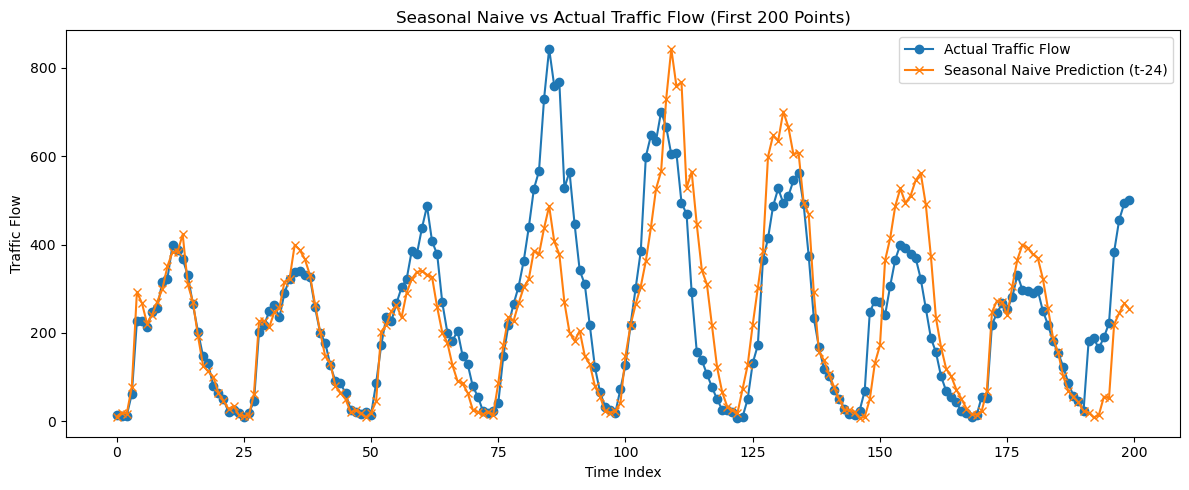

In [94]:
# Plot sample predictions
plt.figure(figsize=(12, 5))
plt.plot(y_true.values[:200], label="Actual Traffic Flow", marker='o')
plt.plot(y_pred.values[:200], label="Seasonal Naive Prediction (t-24)", marker='x')
plt.title("Seasonal Naive vs Actual Traffic Flow (First 200 Points)")
plt.xlabel("Time Index")
plt.ylabel("Traffic Flow")
plt.legend()
plt.tight_layout()
plt.show()

# LSTM Model

In [95]:
# Choose feature set 1
features = X_fs1.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


In [96]:
# Create sequences for multi-step prediction ( 3 days )
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

C:\Users\attafuro\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 72)                  │           9,288 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,384 (302.28 KB)

 Trainable params: 77,384 (302.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 2651s 62ms/step - loss: 2047471.3750 - val_loss: 619457.8750
Epoch 2/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1311s 31ms/step - loss: 1202616.1250 - val_loss: 585223.9375
Epoch 3/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1518s 36ms/step - loss: 1141494.3750 - val_loss: 564986.8750
Epoch 4/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1490s 35ms/step - loss: 965867.6875 - val_loss: 490819.8438
Epoch 5/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1646s 39ms/step - loss: 776265.8125 - val_loss: 482106.8438
Epoch 6/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1391s 33ms/step - loss: 731218.4375 - val_loss: 480688.8750
Epoch 7/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 2660s 62ms/step - loss: 713161.3750 - val_loss: 477633.3125
Epoch 8/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 3936s 92ms/step - loss: 702121.6875 - val_loss: 478022.1562
Epoch 9/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1401s 33ms/step - loss: 693779.1875 - val_loss: 471741.5938
Epoch 10/10
42706/42706 ━━━━━━━━━━━━━━━━━━━━ 1473s 34ms/step 

In [ ]:
model.save("lstm_traffic_model.fs1")

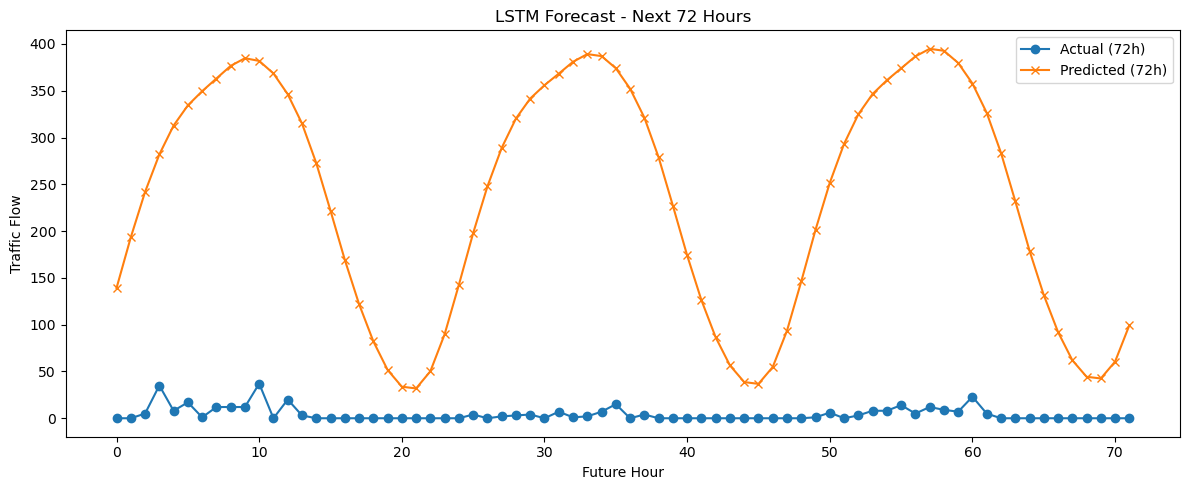

In [ ]:
# Plot a sample 72-hour prediction vs actual ===
plt.figure(figsize=(12, 5))
plt.plot(y_test[0], label="Actual (72h)", marker='o')
plt.plot(y_pred[0], label="Predicted (72h)", marker='x')
plt.title("LSTM Forecast - Next 72 Hours")
plt.xlabel("Future Hour")
plt.ylabel("Traffic Flow")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Choose feature set 2
features = X_fs2.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

C:\Users\attafuro\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 72)                  │           9,288 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,920 (308.28 KB)

 Trainable params: 78,920 (308.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26193/42706 ━━━━━━━━━━━━━━━━━━━━ 10:09 37ms/step - loss: 2024468.5000

In [ ]:
# Choose feature set 3
features = X_fs3.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

In [ ]:
# Choose feature set 4
features = X_fs4.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

In [ ]:
# Choose feature set 5
features = X_fs5.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

In [ ]:
# Choose feature set 6
features = X_fs6.copy()           
target = df["Total Flow"].values  # Target variable

# Normalize the features 
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
def create_multi_step_sequences(features, target, input_len=24, output_len=72):
    X, y = [], []
    for i in range(input_len, len(features) - output_len):
        X.append(features[i-input_len:i])
        y.append(target[i:i+output_len])
    return np.array(X), np.array(y)

input_len = 24    # past 24 hours
output_len = 72   # next 72 hours (3 days)
X_seq, y_seq = create_multi_step_sequences(features_scaled, target, input_len, output_len)

# Split into train/test sets 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build the LSTM model 
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_len))  # Predict next 72 hours

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Make predictions 
y_pred = model.predict(X_test)

# Evaluate performance 
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))

print("\n Multi-Step LSTM Forecast Evaluation (72 steps):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

# Network Time Series

In [ ]:
from sklearn.cluster import KMeans

# Cluster routes 
cv_routes = df_grouped[["CV"]].dropna()
kmeans = KMeans(n_clusters=4, random_state=42)
cv_routes["Cluster"] = kmeans.fit_predict(cv_routes[["CV"]])

In [ ]:
df = df.merge(cv_routes[["Cluster"]], left_on="Route_encoded", right_index=True, how="left")

In [ ]:
Y = df.pivot(index="Timestamp", columns="Route_encoded", values="Total Flow")
Y = Y.dropna()

In [ ]:
from statsmodels.tsa.api import VAR

cluster_models = {}
forecast_horizon = 72

for cluster_id in cv_routes["Cluster"].unique():
    # Get routes in this cluster
    cluster_routes = cv_routes[cv_routes["Cluster"] == cluster_id].index.tolist()
    cluster_data = Y[cluster_routes].dropna()

    # Limit to recent history
    cluster_data = cluster_data[-2000:]

    # Fit the model
    model = VAR(cluster_data)
    model_fitted = model.fit(maxlags=3)
    forecast = model_fitted.forecast(cluster_data.values[-3:], steps=forecast_horizon)
    forecast_df = pd.DataFrame(forecast, columns=cluster_data.columns)

    # Store for later
    cluster_models[cluster_id] = {
        "model": model_fitted,
        "forecast": forecast_df,
        "actual": Y[cluster_routes].iloc[-forecast_horizon:]
    }

    print(f"Fitted Cluster {cluster_id} with {len(cluster_routes)} routes")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for cluster_id, data in cluster_models.items():
    forecast_df = data["forecast"]
    actual_df = data["actual"]

    print(f"\n Cluster {cluster_id} Evaluation:")
    for route in forecast_df.columns:
        y_true = actual_df[route].values
        y_pred = forecast_df[route].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        print(f"Route {route}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")